# Product Sales Forecasting in Retail Industry (Part 2)

### by Sooyeon Won

### Keywords in Part 2
- Unsupervised Learning
- K-Centroids Diagnostics 
- K-Centroids Clustering/ Segmentation
- Comparisons between Clusters 
- Classification Algorithms - Decision Trees, Random Forest, Boosted Model


## Table of Contents
<ul>
<li><a href="#Introduction">(Part 1) 1. Introduction</a></li> 
<li><a href="#Preparation">(Part 1) 2. Data Preparation</a></li>
<li><a href="#Exploration">(Part 1) 3. Data Exploration</a></li>
<li><a href="#Analysis">(Part 2/ 3) 4. Data Analysis</a></li>
    - (Part 2) 4.1. K-Centroids Diagnostics <br>
    - (Part 2) 4.2. K-Centroids Clustering Analysis<br>
    - (Part 2) 4.3. Classification Models Comparisons <br>
    - (Part 3) 4.4. Time Series Analysis <br>
<li><a href="#Conclusion">(Part 3) 5. Conclusion</a></li>
</ul>

### Datasets from the Analysis Part 1

In [1]:
# Import the relevant libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rc("font", size=14)
import seaborn as sns
sns.set()
sns.set(style="whitegrid", color_codes=True)

In [2]:
# Load the dataset
demographic = pd.read_csv('storedemographicdata.csv')
storeinfo = pd.read_csv('storeinformation.csv')
storesales = pd.read_csv('storesalesdata.csv')

<a id='Analysis'></a>
## 4. Data Analysis

> To improve the product surplus and shortages, different store formats are introduced. Individual store segments will have a different product selection in order to better match local demand. The actual building sizes will not change, just the product selection and internal layouts. The terms "formats" and "segments" will be used interchangeably throughout this project. 
>- **4.1. Determine Store Segments for Existing Stores** <br> The optimal number of store clusters is determined based on 2015 sales data. Percentage values of sales per category per store for clustering (category sales as a percentage of total store sales) are used.<br>
>- **4.2. Cluster the Existing Stores** <br> Using a K-means clustering model, the 85 current stores are segmented into the different store clusters.
>- **4.3. Classification Models Comparisons** <br> Using classification algorithms (decision tree, forest, and boosted model), I predict  the best store format for each of the 10 new stores. 20% of datapoints are hold out as a test dataset. 
>- **4.4. Forecasting (Part 3):** <br> Finally, I forecast a monthly produce category sale based on the full year of 2016 for both existing and new stores.

In [3]:
#  Calculate the percentage of each category sales based on the storesales data. 
store_sales_2015 = storesales.query('Year == 2015').iloc[:, np.r_[0,  4:13]] 
cols = store_sales_2015.iloc[:, 1:].columns
store_sales_2015_df = store_sales_2015.groupby('Store')[cols].sum()
store_sales_2015_df['total_sales'] = store_sales_2015_df.sum(axis=1)
pct_sales_per_category_2015 = store_sales_2015_df.div(store_sales_2015_df['total_sales'],axis =0)
pct_sales_per_category_2015 = pct_sales_per_category_2015.iloc[:, :-1]
pct_sales_per_category_2015

,Dry_Grocery,Dairy,Frozen_Food,Meat,Produce,Floral,Deli,Bakery,General_Merchandise
Store,,,,,,,,,
S0001,0.461347,0.103084,0.077199,0.107677,0.097171,0.006769,0.043550,0.035544,0.067658
S0002,0.457528,0.106388,0.078841,0.114903,0.101259,0.007438,0.039792,0.029702,0.064149
S0003,0.421349,0.102356,0.069027,0.114713,0.125399,0.009631,0.041761,0.036108,0.079655
S0004,0.454560,0.097111,0.080277,0.127728,0.100409,0.006120,0.041785,0.034469,0.057542
S0005,0.440169,0.106268,0.086339,0.101863,0.131112,0.008877,0.035389,0.022607,0.067376
...,...,...,...,...,...,...,...,...,...
S0081,0.423280,0.102089,0.086592,0.123493,0.116666,0.008475,0.038956,0.042944,0.057506
S0082,0.460995,0.100760,0.075290,0.113610,0.101490,0.005269,0.048267,0.035212,0.059107
S0083,0.447873,0.108865,0.083793,0.109469,0.117443,0.007097,0.031885,0.025206,0.068370


### 4.1. K-Centroids Diagnostics 

> For a desirable cluster analysis, we should find the optimal number of clusters. I arrive at the optimal number, according to the following three criterion: 
> - 4.1.1. Elbow Method
> - 4.1.2. Silhouette Coefficient
> - 4.1.3. Adjusted Rand Indices(ARI) & Calinski-Harabasz Index(CHI) <br>

> Remember that Clustering algorithms such as K-means are very sensitive to scale the variables. Therefore, feature scaling should be preceded before they are fed to the algorithms, because clustering techniques bascially use Euclidean Distance to form the cohorts. 

In [4]:
# Import the relevant libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Scale the features before proceeding clustering analysis.
scaler = StandardScaler()
# Feature values (the proportion of each category) per store are scaled.
pct_sales_scaled = scaler.fit_transform(pct_sales_per_category_2015.T).T 

### 4.1.1. Elbow Method 

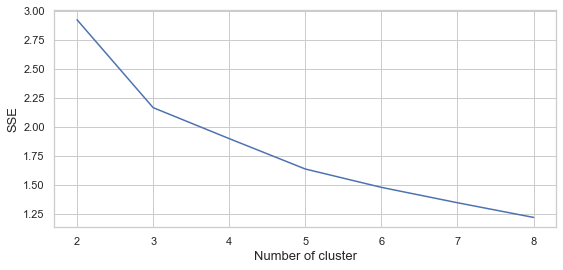

In [5]:
from kneed import KneeLocator
kmeans_kwargs = { "init": "k-means++",  "n_init": 10,  "max_iter": 1000,  "random_state": 468 }

# A list holds the SSE values for each k
sse = {}
for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pct_sales_scaled)
    sse[k] = kmeans.inertia_


plt.figure(figsize=[9,4])
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster", fontsize = 13)
plt.ylabel("SSE", fontsize = 13)
plt.show()

In [6]:
from kneed import KneeLocator
x, y = list(sse.keys()), list(sse.values())
kn = KneeLocator(x, y, curve='convex', direction='decreasing')
print('The optimal number of clusters, suggested by Elbow criterion: ', kn.knee)

The optimal number of clusters, suggested by Elbow criterion:  3


### 4.1.2. Silhouette Coefficient

>- The silhouette coefficient is a measure of cluster cohesion and separation. It tells how well a data point fits into its assigned cluster based on two factors:
    > 1. Within-Cluster Distance  (i.e. How close the data point is to other points in the cluster)
    > 2. Between-Clusters Distance (i.e. How far away the data point is from points in other clusters)
>- Silhouette coefficient values range between -1 and 1. Larger numbers mean that samples are closer to their clusters than they are to other clusters. 
>- The function "silhouette_score" from scikit-learn returns the average silhouette coefficient of all the samples is summarized into one score. The silhouette score() function requires at least two clusters. For this report, I compare the silhouette coefficients of different number of clusters using for-loop. 

In [7]:
from sklearn.metrics import silhouette_score
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pct_sales_scaled)
    score = silhouette_score(pct_sales_scaled, kmeans.labels_) 
    silhouette_coefficients.append(score)

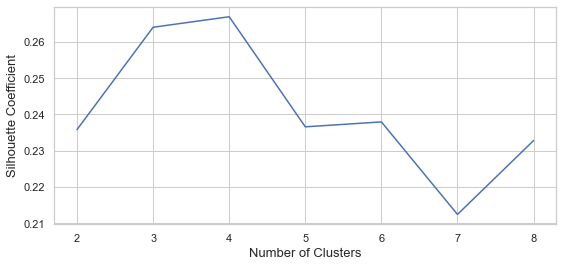

In [8]:
plt.figure(figsize=[9,4])
plt.plot(range(2, 9), silhouette_coefficients)
plt.xticks(range(2, 9))
plt.xlabel("Number of Clusters", fontsize = 13)
plt.ylabel("Silhouette Coefficient", fontsize = 13)
plt.show()

> **Findings:** The optimal number of clusters, suggested by Silhouette Coefficient is 4. Since the Silhouette Coefficient for 3 clusters are very close to the coefficent for 4 clusters, we can think that 3 clusters are the second most optimal number of clusters. 

### 4.1.3. Adjusted Rand Indices(ARI) & Calinski-Harabasz Index(CHI)

In Alteryx. the appropriate number of clusters is diagnosed based on Adjusted Rand Indices(ARI) and Calinski-Harabasz Index(CHI). The optimal number of clusters based on the calculations of two different statistics over bootstrap replicate samples of the original data for a range of clustering solution that differ in the number of clusters specified.

This approach is based on the idea that if the datapoints truly classified into a set of stable clusters, then a set of different random samples of the datapoints should result in approximately the set of clusters across the bootstrap replicates, except for small differences that are due to both random sample variability and to the randomness induced by the method used to generate the starting set of centroids, via selecting K points at random, in the general K-Centroids algorithm. The two measures examined are the adjusted Rand index and the Calinski–Harabasz index (also known as the variance ratio criteria and the pseudo-F statistic).

This can be a very computationally intensive process, depending on the number of records used in the calculation, the number of different clustering solutions examined (determined by range between the designated minimum and maximum number of clusters), the number of bootstrap replicates, and the number of different starting seeds used for each cluster solution (the number of starting seed is set to 10 seeds in this analysis). 

Reducing the number of bootstrap replicates to use greatly reduced the amount of computer time needed. However, it can also bring a large cost of precision. Alteryx recommends to use at least 100 replicates if possible. Thus, I used 100 bootstrap replicates for the actual analysis. [Reference](https://help.alteryx.com/current/designer/k-centroids-diagnostics-tool)

In [9]:
# Import the relevant libraries 
from sklearn.metrics.cluster import adjusted_rand_score, calinski_harabasz_score

### Adjusted Rand Indices(ARI)

The Adjusted Rand index provides a measure of similarity between two different clustering solutions. The AR-index takes a maximum value of one, when the two clustering solutions perfectly overlap. For this analysis the index is used to determine both the relative and absolute reproducibility of a clustering solution by comparing pairs of solutions, where each pair is based on a different sample of customer data. The greater the overlap between pairs of solutions implies the greater the reproducibility of the cluster structure. [Wiki Reference](https://en.wikipedia.org/wiki/Rand_index#Adjusted_Rand_index)

In [10]:
cluster_ari_all=[]

for k in range(2,9): # Compare 2 - 8 Clusters solutions 
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans_btsp = KMeans(n_clusters=k, init = 'random', n_init=10, algorithm= 'elkan', random_state=3)
    existing_stores= pct_sales_per_category_2015.index
    cluster_ari = []
    
    for _ in range(100):  # Bootstrapping with 100 replicates 
        
        btsp_rnd = np.random.choice(existing_stores, 85)      
        btsp_rnd_df = pct_sales_per_category_2015.loc[btsp_rnd]
        btsp_rnd_scaled = scaler.fit_transform(btsp_rnd_df)
        
        btsp_rnd_fitted = kmeans_btsp.fit(btsp_rnd_scaled)
        rnd_label = btsp_rnd_fitted.labels_

        original_fitted= kmeans.fit(btsp_rnd_scaled)
        true_algo_labels = original_fitted.labels_
    
        ari = adjusted_rand_score(true_algo_labels, rnd_label)
        cluster_ari.append(ari)
    cluster_ari_all.append(cluster_ari)    

In [11]:
cluster_ari_all = pd.DataFrame(cluster_ari_all, 
                               index =['cluster2', 'cluster3','cluster4', 'cluster5', 'cluster6', 'cluster7', 'cluster8'])
cluster_ari_all = cluster_ari_all.T

In [12]:
cluster_ari_all.describe()

,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.917719,0.748498,0.681890,0.624232,0.611453,0.575823,0.581418
std,0.156733,0.214858,0.193652,0.161667,0.137459,0.133815,0.121038
min,0.050168,0.188360,0.228919,0.304118,0.320311,0.243398,0.289484
25%,0.906976,0.620260,0.539148,0.509054,0.514072,0.484472,0.515321
50%,1.000000,0.808880,0.703534,0.610234,0.613807,0.570425,0.588763
75%,1.000000,0.922869,0.834020,0.756051,0.709976,0.673203,0.651643
max,1.000000,1.000000,1.000000,1.000000,0.941042,0.853073,0.835399


Text(0.5, 1.0, 'Adjusted Rand Indices')

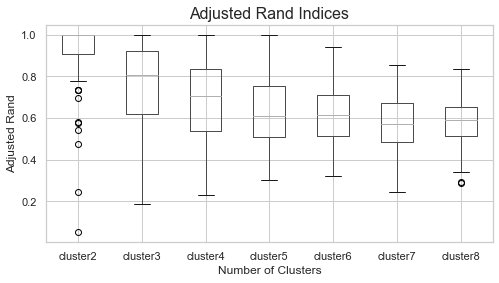

In [13]:
cluster_ari_all.boxplot(figsize = (8,4))
plt.ylabel('Adjusted Rand')
plt.xlabel('Number of Clusters')
plt.title('Adjusted Rand Indices', fontsize = 16)

### Calinski-Harabasz Index(CHI)

The Calinski–Harabasz index is based on comparing the weighted ratio of the between cluster sum of squares (the measure of cluster separation) and the within cluster sum of squares (the measure of how tightly packed the points are within a cluster). Ideally, the clusters should be well separated, so that the between cluster sum of squares value should be large, but points within a cluster should be as close as possible to one another, resulting in smaller values of the within cluster sum of squares measure. Since the Calinski–Harabasz index is a ratio, with the between cluster sum of squares in the numerator and the within cluster sum of squares in the denominator, cluster solutions with larger values of the index correspond to “better” solutions than cluster solutions with smaller values. [Alteryx- Reference](https://help.alteryx.com/current/designer/k-centroids-diagnostics-tool)

In [14]:
cluster_chi_all=[]

for k in range(2,9):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans_btsp = KMeans(n_clusters=k, init = 'random', n_init=10, algorithm = 'elkan')
    existing_stores= pct_sales_per_category_2015.index
    cluster_chi = []
    for _ in range(100): 
        btsp_rnd = np.random.choice(existing_stores, 85)
        btsp_rnd_df = pct_sales_per_category_2015.loc[btsp_rnd]
        btsp_rnd_scaled = scaler.fit_transform(btsp_rnd_df)

        btsp_rnd_fitted = kmeans_btsp.fit(btsp_rnd_scaled)
        rnd_label = btsp_rnd_fitted.labels_

        chi = calinski_harabasz_score(btsp_rnd_scaled,rnd_label)
        cluster_chi.append(chi)
    cluster_chi_all.append(cluster_chi)

In [15]:
cluster_chi_all = pd.DataFrame(cluster_chi_all, 
                               index =['cluster2', 'cluster3','cluster4', 'cluster5', 'cluster6', 'cluster7', 'cluster8'])
cluster_chi_all = cluster_chi_all.T

In [16]:
cluster_chi_all.describe()

,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,25.111713,22.517965,20.995403,19.877663,19.800934,19.058298,18.955674
std,2.973955,2.103197,1.926888,1.918141,1.935923,2.002820,2.239280
min,16.945949,17.812153,17.761768,15.891173,16.050354,15.099547,13.816299
25%,23.036936,20.978217,19.642789,18.458781,18.378778,17.629112,17.490388
50%,24.678782,22.430473,20.938414,19.947174,19.783325,19.074290,18.812167
75%,26.918283,23.961390,21.995276,21.013596,20.940812,20.072251,19.936843
max,33.679226,27.360442,29.200094,27.175647,25.013302,25.123402,30.618711


Text(0.5, 1.0, 'Calinski-Harabasz Indices (CH index)')

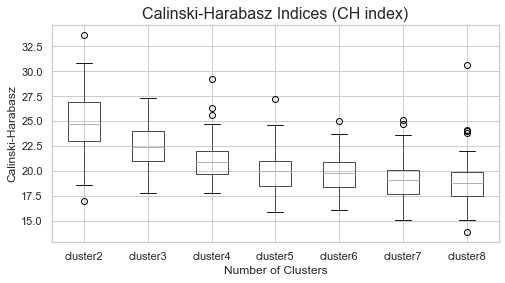

In [17]:
cluster_chi_all.boxplot(figsize = (8,4))
plt.ylabel('Calinski-Harabasz')
plt.xlabel('Number of Clusters')
plt.title('Calinski-Harabasz Indices (CH index)', fontsize = 16)

> The output plots show the information about the distribution of the two statistics for differing numbers of clusters across the bootstrap replicates. The information is presented via two box and whisker plots (one each for the adjusted Rand index and the Calinski-Harabasz index) and summary statistics for the two indices. The preferred number of clusters based on each measure corresponds to one with the highest mean and median of the solutions compared. Additionally , it is desirable that dispersion in the calculated statistics across the bootstrap replicates not be too large. [Alteryx- Reference](https://help.alteryx.com/current/designer/k-centroids-diagnostics-tool)

> **Findings:** According to the summary statistics and the box plots for both measures, two clusters are the most appropriate and the three clusters solution is the second best option. According to the Rand Index and CH Index, the mean and median values under two- and three-cluster solutions are higher than other cluster solutions. Considering all the previous suggestions from Elbow Method and Silhouette Coefficient, I decided to use three clusters in this analysis. 

### 4.2. K-Centroids  Clustering Analysis

### 4.2.1. Cluster the Existing Stores

> So far, I have concluded that the optimal number of clusters for this analysis three. In this section, using the selected number of clusters. I group the 85 existing stores into three clusters. 

In [18]:
# Define the cluster algorithm 
kmeans_threeclusters = KMeans(init="k-means++", n_clusters=3,  n_init=10, max_iter=1000, random_state = 468)
# Unlike the previous standardisation, I scaled the feature values per category. 
pct_sales_per_ctg_scaled = scaler.fit_transform(pct_sales_per_category_2015)

In [19]:
pct_sales_fitted = kmeans_threeclusters.fit(pct_sales_per_ctg_scaled)
pct_sales_fitted.inertia_ # Sum of squared distances of samples to their closest cluster center.

514.0107416154974

In [20]:
# Coordinates of cluster centers. 
kmeans_threeclusters.cluster_centers_

array([[ 0.32977822, -0.76553245, -0.39151866, -0.08668726, -0.51220691,
        -0.30331307, -0.23396997, -0.89956863,  1.21568783],
       [-0.73506893,  0.70677913,  0.34795085, -0.48868677,  1.02052807,
         0.85677311, -0.55793247,  0.39927883, -0.30667177],
       [ 0.41612424, -0.08755601, -0.03289835,  0.4898704 , -0.539835  ,
        -0.54152181,  0.65337427,  0.27609068, -0.57779814]])

In [21]:
# Cluster labels of each datapoint
pct_sales_fitted.labels_  

array([2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 0, 0, 0, 0, 2, 1, 2, 0, 2, 1, 2,
       1, 2, 2, 1, 1, 2, 0, 2, 0, 0, 2, 1, 2, 0, 0, 2, 2, 0, 2, 2, 1, 2,
       0, 1, 0, 0, 1, 1, 1, 1, 2, 2, 0, 1, 2, 2, 0, 2, 2, 0, 1, 1, 1, 0,
       2, 1, 1, 0, 0, 0, 1, 2, 2, 1, 1, 1, 0, 0, 1, 2, 1, 2, 1])

In [22]:
# The number of stores fall into each store cluster. 
store_cluster_no = pd.DataFrame(pct_sales_fitted.labels_, columns = ['cluster'],index =pct_sales_per_category_2015.index )
store_cluster_no['cluster'].replace({0: "A", 1: "B", 2: "C"}, inplace=True)
store_cluster_no.cluster.value_counts()
# The results can be varied, depending on the random_state setting.

C    33
B    29
A    23
Name: cluster, dtype: int64

> **Findings:** Percentage sales per category per store are used for clustering. Stores are quite evenly
assigned to each format. 23, 29, 33 stores fall into each store cluster. Then I merged the labels with 2015 sales dataframe, to compare between the three clusters. To avoid confusion, I replace the numeric labels (0.1.2) with alphabetical labels (A, B, C), respectively. 

In [23]:
# Merge the store cluster number dataframe(store_cluster_no) with percentage of each product category dataframe. 
pct_per_category_cluster = pct_sales_per_category_2015.merge(store_cluster_no, how = 'inner', 
                                left_on = pct_sales_per_category_2015.index,
                                 right_on = store_cluster_no.index, right_index=True ).iloc[:, 1:]

In [24]:
# Percentage of each product category and cluster
pct_per_category_cluster.head()

,Dry_Grocery,Dairy,Frozen_Food,Meat,Produce,Floral,Deli,Bakery,General_Merchandise,cluster
Store,,,,,,,,,,
S0001,0.461347,0.103084,0.077199,0.107677,0.097171,0.006769,0.043550,0.035544,0.067658,C
S0002,0.457528,0.106388,0.078841,0.114903,0.101259,0.007438,0.039792,0.029702,0.064149,C
S0003,0.421349,0.102356,0.069027,0.114713,0.125399,0.009631,0.041761,0.036108,0.079655,B
S0004,0.454560,0.097111,0.080277,0.127728,0.100409,0.006120,0.041785,0.034469,0.057542,C
S0005,0.440169,0.106268,0.086339,0.101863,0.131112,0.008877,0.035389,0.022607,0.067376,B


In [25]:
# Scaled percentage data (within each product category) merged with Cluster number. 
pct_per_category_scaled_df = pd.DataFrame(scaler.fit_transform(pct_sales_per_category_2015), 
                                          columns=pct_sales_per_category_2015.columns, 
                                          index = pct_sales_per_category_2015.index)

scaled_pct_cluster_df = pct_per_category_scaled_df.merge(store_cluster_no, how = 'inner', 
                                left_on = pct_per_category_scaled_df.index,
                                 right_on = store_cluster_no.index, right_index=True ).iloc[:, 1:]
scaled_pct_cluster_df

,Dry_Grocery,Dairy,Frozen_Food,Meat,Produce,Floral,Deli,Bakery,General_Merchandise,cluster
Store,,,,,,,,,,
S0001,0.809075,0.123437,-0.345390,-0.297199,-0.869242,-0.605960,0.624934,1.139692,-0.380775,C
S0002,0.575979,0.684180,-0.018513,0.293169,-0.583907,-0.314143,-0.135248,0.258721,-0.627521,C
S0003,-1.632047,-0.000024,-1.972473,0.277587,1.100833,0.643122,0.262976,1.224759,0.462742,B
S0004,0.394833,-0.890256,0.267452,1.340907,-0.643243,-0.889562,0.267921,0.977567,-1.092061,C
S0005,-0.483467,0.663894,1.474338,-0.772215,1.499572,0.313982,-1.026059,-0.811087,-0.400609,B
...,...,...,...,...,...,...,...,...,...,...
S0081,-1.514208,-0.045448,1.524851,0.994903,0.491319,0.138541,-0.304474,2.255616,-1.094593,B
S0082,0.787575,-0.271021,-0.725565,0.187492,-0.567811,-1.260659,1.579192,1.089706,-0.981987,C
S0083,-0.013295,1.104562,0.967546,-0.150834,0.545597,-0.462985,-1.735071,-0.419119,-0.330752,B


### 4.2.2. Clusters Comparison

> In this section, I compare the three clusters, based on the the results of the clustering model. The different characteristic are also visaully explained. 

#### Cluster means of Individual Variables

In [26]:
cols =scaled_pct_cluster_df.columns[:-1]
scaled_pct_cluster_df.groupby('cluster')[cols].mean()

,Dry_Grocery,Dairy,Frozen_Food,Meat,Produce,Floral,Deli,Bakery,General_Merchandise
cluster,,,,,,,,,
A,0.329778,-0.765532,-0.391519,-0.086687,-0.512207,-0.303313,-0.233970,-0.899569,1.215688
B,-0.735069,0.706779,0.347951,-0.488687,1.020528,0.856773,-0.557932,0.399279,-0.306672
C,0.416124,-0.087556,-0.032898,0.489870,-0.539835,-0.541522,0.653374,0.276091,-0.577798


> **Findings:** Cluster "A" shows large negative number in the bakery category and large positive number in the category of general merchandise. We can understand the figures that the bakery products are **less** likely to be sold at stores in Cluster "A", comparing to the stores in other clusters. On the other hand, the products in general merchandise category are more likely to be sold. This fact can be also confirmed from the average proportion plot of general merchandise sales. See the barplot below. (Graph 1: General Merchandise Category Comparison between Clusters)

> Unlike Cluster "A" and Cluster "C", the stores in Cluster "B" have relatively high sales on "Produce, Dairy, and Floral" product categories. I visualized the average sales of Produce product in each cluster (Graph 2). On the other hand, Cluster "B" shows less sales on the dried grocery products comparing to other clusters. Cluster "C" has relatively higher sales on "Meat" and "Delicatessen" products. (Graph 3)

Text(0.5, 1.0, 'Graph 1: General Merchandise Category Comparison between Clusters')

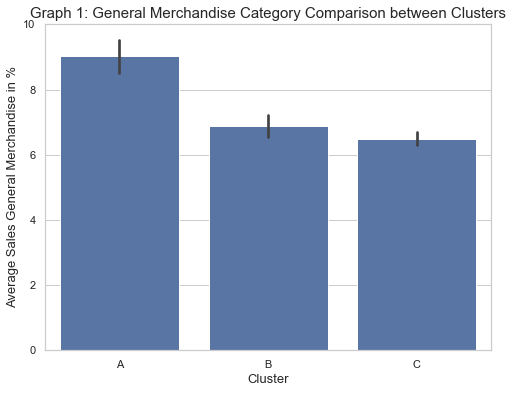

In [27]:
pct_per_category_cluster[['General_Merchandise', 
                          'Produce', 'Deli']] = pct_per_category_cluster[['General_Merchandise', 'Produce', 'Deli']]*100
base_color = sns.color_palette()[0]
cluster_order= ['A', 'B', 'C']

plt.figure(figsize=[8,6])
sns.barplot(data = pct_per_category_cluster, x = 'cluster', y = 'General_Merchandise',color = base_color, order = cluster_order)
plt.ylabel('Average Sales General Merchandise in %', fontsize = 13)
plt.xlabel('Cluster', fontsize = 13)
plt.title('Graph 1: General Merchandise Category Comparison between Clusters', fontsize = 15)

Text(0.5, 1.0, 'Graph 2: Produce Category Comparison between Clusters')

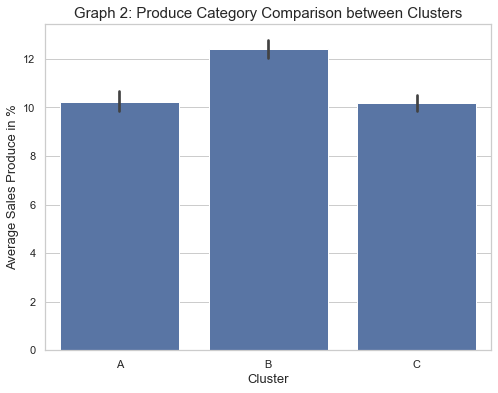

In [28]:
plt.figure(figsize=[8,6])
sns.barplot(data = pct_per_category_cluster, x = 'cluster', y = 'Produce',color = base_color, order = cluster_order)
plt.ylabel('Average Sales Produce in %', fontsize = 13)
plt.xlabel('Cluster', fontsize = 13)
plt.title('Graph 2: Produce Category Comparison between Clusters', fontsize = 15)

Text(0.5, 1.0, 'Graph 3: Deli Category Comparison between Clusters')

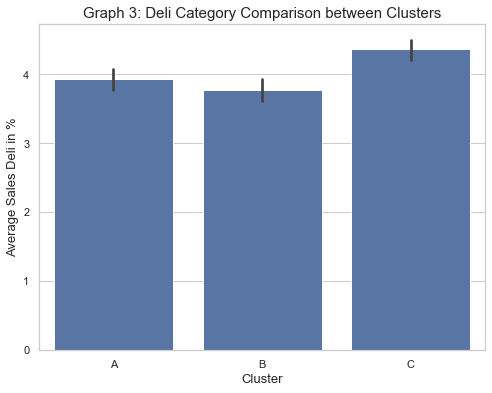

In [29]:
plt.figure(figsize=[8,6])
sns.barplot(data = pct_per_category_cluster, x = 'cluster', y = 'Deli',color = base_color, order = cluster_order)
plt.ylabel('Average Sales Deli in %', fontsize = 13)
plt.xlabel('Cluster', fontsize = 13)
plt.title('Graph 3: Deli Category Comparison between Clusters', fontsize = 15)

### 4.3. Classification Models Comparisons

> As earlier mentioned, the grocery store chain has 10 new stores opening up at the beginning of the year. Eventually, we want to predict the expected sales for these new stores, although there is no sales data for them yet. In this case, it seems more reasonable to match the most appropriate clusters with each of new store, and then predict the expected sales of new stores based on the matched clusters sales information. Therefore, I determine the cluster using each of the new store’s demographic data. In general, we use PCA to reduce the number of predictor variables. However, I leave all predictor variables in the model.<br><br> In this section, I matched which store cluster, each of the new stores should have, based on the demographic information using Classification Models. Note that we have three clusters, which is non-binary. Therefore Logistic Regression Model can not be applied. Instead, I applied (1) Decision Tree, (2) Random Forest and (4) Gradient Boosting models for this analysis. 


In [30]:
# I merged the cluster information with the demographic data for each store
demographic_cluster = demographic.merge(store_cluster_no, how ='inner' ,
                                        left_on = demographic['Store'], right_on = store_cluster_no.index).iloc[:, 1:]

In [31]:
demographic_cluster.shape 
# Except for the store number and cluster columns, there are 44 demographic features in the dataset.

(85, 46)

In [32]:
demographic_cluster.head()  # Glance at the demographic_cluster dataset

,Store,Age0to9,Age10to17,Age18to24,Age25to29,Age30to39,Age40to49,Age50to64,Age65Plus,EdLTHS,...,PopWhite,HVal0to100K,HVal100Kto200K,HVal200Kto300K,HVal300Kto400K,HVal400Kto500K,HVal500Kto750K,HVal750KPlus,PopDens,cluster
0,S0001,0.138163,0.111414,0.113228,0.081671,0.134924,0.128832,0.160429,0.131359,0.241935,...,0.454295,0.073853,0.115967,0.223511,0.301880,0.180786,0.097168,0.006836,4260.943672,C
1,S0002,0.138954,0.112723,0.100572,0.074832,0.121080,0.146961,0.195456,0.109422,0.125224,...,0.729696,0.124956,0.127915,0.206578,0.223808,0.174730,0.129133,0.012879,3061.060073,C
2,S0003,0.108582,0.091262,0.113486,0.111415,0.182909,0.144938,0.150248,0.097170,0.321860,...,0.182080,0.024665,0.065257,0.114870,0.150106,0.155462,0.251445,0.238196,13740.923328,B
3,S0004,0.142758,0.102582,0.083941,0.062370,0.131661,0.134041,0.158762,0.183922,0.198362,...,0.516900,0.175374,0.112920,0.095161,0.247891,0.152583,0.161462,0.054610,2947.367203,C
4,S0005,0.112396,0.083652,0.091313,0.103056,0.183739,0.146511,0.165692,0.113630,0.164272,...,0.396718,0.021852,0.022854,0.070837,0.113448,0.126377,0.208777,0.435855,12124.740209,B


In [33]:
# Import the relevant libraries. 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
# Evaluations
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [34]:
# Load dataset
inputs = demographic_cluster.iloc[:, 1:45]
target = demographic_cluster.iloc[:, -1]

# Split into train/test sets
train_X, test_X, train_y, test_y = train_test_split(inputs, target, test_size=0.20, random_state=33)

In [35]:
train_X.shape, train_y.shape

((68, 44), (68,))

### 4.3.1. Deicision Tree

In [36]:
# Define and fit a model
model_dt = DecisionTreeClassifier(class_weight='balanced', random_state=33)
model_dt.fit(train_X, train_y)

# Predict the test set results
ypred_dt = model_dt.predict(test_X) # Predict class labels for samples in X.
ypred_prob_dt = model_dt.predict_proba(test_X) # Probability estimates.

# Retrieve the probabilities for the positive class
yhat_positive_dt = ypred_prob_dt[:, 1]

In [37]:
# Confusion Matrix for Decision Tree Model 
cm_dt = confusion_matrix(test_y, ypred_dt)
cm_dt

array([[2, 0, 0],
       [0, 4, 3],
       [1, 1, 6]], dtype=int64)

In [38]:
# Evaluation Metrics: "Precision", Recall, F-Score
print('Decision Tree Model: ') 
print(classification_report(test_y, ypred_dt))

Decision Tree Model: 
              precision    recall  f1-score   support

           A       0.67      1.00      0.80         2
           B       0.80      0.57      0.67         7
           C       0.67      0.75      0.71         8

    accuracy                           0.71        17
   macro avg       0.71      0.77      0.72        17
weighted avg       0.72      0.71      0.70        17



### 4.3.2. Random Forest

In [39]:
# Define and fit a model
model_rf=  RandomForestClassifier(random_state=33)
model_rf.fit(train_X, train_y)

# Predict the test set results
ypred_rf = model_rf.predict(test_X) # Predict class labels for samples in X.
ypred_prob_rf = model_rf.predict_proba(test_X) # Probability estimates.

# Retrieve the probabilities for the positive classra
yhat_positive_rf = ypred_prob_rf[:, 1]

In [40]:
# Confusion Matrix for Random Forest Model
cm_rf = confusion_matrix(test_y, ypred_rf)
cm_rf

array([[0, 0, 2],
       [0, 5, 2],
       [1, 1, 6]], dtype=int64)

In [41]:
# Evaluation Metrics: "Precision", Recall, F-Score
print('Random Forest Model: ') 
print(classification_report(test_y, ypred_rf))

Random Forest Model: 
              precision    recall  f1-score   support

           A       0.00      0.00      0.00         2
           B       0.83      0.71      0.77         7
           C       0.60      0.75      0.67         8

    accuracy                           0.65        17
   macro avg       0.48      0.49      0.48        17
weighted avg       0.63      0.65      0.63        17



### 4.3.3. Gradient Boosting Model

In [42]:
# Define and fit a model
model_gbm = GradientBoostingClassifier(random_state=33)
model_gbm.fit(train_X, train_y)

# Predict the test set results
ypred_gbm = model_gbm.predict(test_X) # Predict class labels for samples in X.
ypred_prob_gbm = model_gbm.predict_proba(test_X) # Probability estimates.

# Retrieve the probabilities for the positive class
yhat_positive_gbm = ypred_prob_gbm[:, 1]

In [43]:
# Confusion Matrix for Gradient Boosting Model
cm_gbm = confusion_matrix(test_y, ypred_gbm)
cm_gbm

array([[1, 0, 1],
       [0, 5, 2],
       [0, 1, 7]], dtype=int64)

In [44]:
# Evaluation Metrics: "Precision", Recall, F-Score
print('GradientBoosting Model: ') 
print(classification_report(test_y, ypred_gbm))

GradientBoosting Model: 
              precision    recall  f1-score   support

           A       1.00      0.50      0.67         2
           B       0.83      0.71      0.77         7
           C       0.70      0.88      0.78         8

    accuracy                           0.76        17
   macro avg       0.84      0.70      0.74        17
weighted avg       0.79      0.76      0.76        17



Feature: Age0to9, Score: 0.323764
Feature: Age10to17, Score: 0.054625
Feature: Age18to24, Score: 0.000690
Feature: Age25to29, Score: 0.008759
Feature: Age30to39, Score: 0.000177
Feature: Age40to49, Score: 0.000369
Feature: Age50to64, Score: 0.001382
Feature: Age65Plus, Score: 0.030976
Feature: EdLTHS, Score: 0.001813
Feature: EdHSGrad, Score: 0.000026
Feature: EdSomeCol, Score: 0.003101
Feature: EdAssociate, Score: 0.009231
Feature: EdBachelor, Score: 0.000603
Feature: EdMaster, Score: 0.133167
Feature: EdProfSchl, Score: 0.000469
Feature: EdDoctorate, Score: 0.000014
Feature: HHSz1Per, Score: 0.008574
Feature: HHSz2Per, Score: 0.022388
Feature: HHSz3Per, Score: 0.010228
Feature: HHSz4Per, Score: 0.010424
Feature: HHSz5PlusPer, Score: 0.020012
Feature: HHIncU25K, Score: 0.002478
Feature: HHInc25Kto50K, Score: 0.003704
Feature: HHInc50Kto75K, Score: 0.014765
Feature: HHInc75Kto100K, Score: 0.020228
Feature: HHInc100Kto150K, Score: 0.006498
Feature: HHInc150Kto250K, Score: 0.000000
Featu

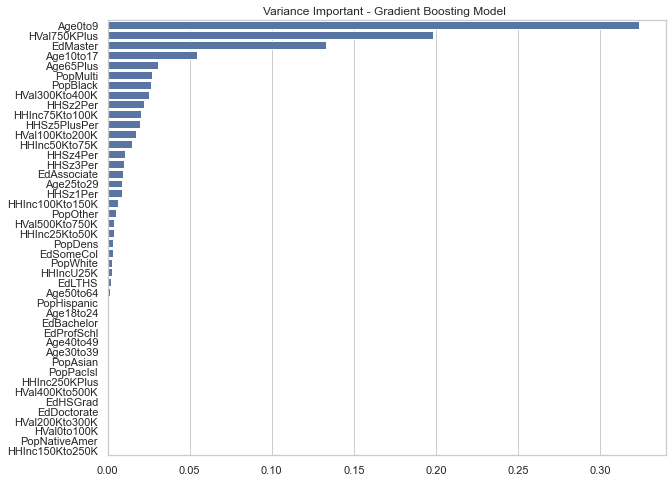

In [45]:
plt.figure(figsize=(10,8))
# get importance
importance_gbm = model_gbm.feature_importances_

features_gbm = dict(zip(train_X.columns, importance_gbm))
features_sorted_gbm = sorted(features_gbm, key=features_gbm.get, reverse=True)

# summarize feature importance
for i,v in zip(train_X.columns, importance_gbm):
    print('Feature: {}, Score: {:5f}' .format(i,v))
# plot feature importance
base_color = sns.color_palette()[0]
sns.barplot(y = [x for x in train_X.columns ], x= importance_gbm , color = base_color, order = features_sorted_gbm)
plt.title('Variance Important - Gradient Boosting Model ')
plt.show();

> Based on the confusion matrices, the Gradient Boosting Model achieved the largest number of correct predictions. Also, the overall accuracy rate shows that the Boosted Model shows the best performance. According to the Variable Importance Plot in the Boosted Model report, “Age0to9”, “HVal750KPlus”, “EdMaster” are the three most important variables which explain the relationship between the demographic factors and store clusters. Note that the results can be different depending on the random seeds. 

> Now, I predict the most desirable clusters for each new store using the Gradient Boosting Model.

In [46]:
new_stores= storeinfo.query('Type=="New"')
new_stores_demo = new_stores.merge(demographic, how = 'inner', left_on = 'Store', right_on ='Store')
new_stores_demo_lic = new_stores_demo.iloc[:, 6:] 

In [47]:
new_stores_cluster = pd.DataFrame( {'Store':new_stores_demo.Store , 'cluster': model_gbm.predict(new_stores_demo_lic) } )
new_stores_cluster['Type'] = 'New'
new_stores_cluster

,Store,cluster,Type
0,S0086,C,New
1,S0087,B,New
2,S0088,C,New
3,S0089,B,New
4,S0090,B,New
5,S0091,A,New
6,S0092,B,New
7,S0093,A,New
8,S0094,B,New
9,S0095,B,New


> According to the prediction based on Gradient Boosting Model, 2, 6, 2 new stores are included in A, B, C clusters, respectively. 

In [48]:
store_cluster_no['Type'] = 'Existing'
all_store_cluster = store_cluster_no.reset_index().append(new_stores_cluster)
all_store_cluster

,Store,cluster,Type
0,S0001,C,Existing
1,S0002,C,Existing
2,S0003,B,Existing
3,S0004,C,Existing
4,S0005,B,Existing
...,...,...,...
5,S0091,A,New
6,S0092,B,New
7,S0093,A,New
8,S0094,B,New


In [49]:
# Export the findings as a csv file for the 3rd part of analysis
all_store_cluster.to_csv('all_store_cluster.csv',index=False)

### 4.4. Forecasting Produce Sales

The forecasting analysis will be continued in the third part of analysis. 